# Yelp Spammer Detection



## Introduction


### Motivation

With the popularization of the computer and the developing of the internet, ranking websites such as Yelp, Imdb, IGN become popular in the society. More and more people rely on review system when making their options. In order to build up a robust review system, it is very important to find out which reviews are reliable and fair. 
This project is going to find out what kind of features in either reviews or users might end up with a spam or spammer. We choose Yelp restaurant reviews in Pittsburgh area as our datasets. Apply different machine learning methods to get the hypothesis features that might led to a spam or spammer.

### Abstract

First, we focus on every single reviews and figure out what kinds of features is most likely to be a spam feature. However, even if we can sort out the spam precisely and delete it, these spams might come out again and again. Therefore, next step, we focus on finding the specific features in users that a spammers may have. We can track down those users and block their membership. The final step is to find out the possible restaurants that are hiring spammers. We can warn those restaurant or cancel their post if need it. Our goal is to make a robust review system without spams and spammers.   

### Required Libraries

In [59]:
import nltk
import nltk.tokenize.punkt
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.sentiment.util import *

import io, time, json
import sys
from datetime import *
import math

import requests
from bs4 import BeautifulSoup
from collections import OrderedDict
import codecs
import re

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("svg")
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import random
from time import sleep

# import yelp client library
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator

from utilities import *

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Data acqusition

### Crawler

We starts with 1000 restaurants in Pittsburgh and obtained their reviews and a list of users who reviewed this restaurant. 
	
Note: The crawler can take up to 24-48 hours to complete so we do not recommend running via ipython book. The result files of the crawler can be found here: https://drive.google.com/drive/folders/0B7sRvr6KeBNsQ21nLUREM01DTVU
For the rest of this report, we will assume the data is already been acquired and placed in the folder.

### Data acqusition Summary

For exploration and validation purpose, we have two difference source of data: Pittsburgh and New York City.

The intention is to investigate if there are different and common characteristics between two locations in the repects of review, restaurant and user levels. The crawling result gave us:

* Pittsburgh
    * businessesIdMapping.tsv - 893 different restaurants in Pittsburgh
    * reviews_content_all.tsv - 89331 unique reviews of those 892 restaurants
    * user_id_mapping_all.tsv - 35158 unique users who write those reviews
    * metaData_all.tsv - graph relationships between restaurants and users


* New York City
    * businessesIdMapping_nyc.tsv - 923 different restaurants in Pittsburgh
    * reviews_content_all_nyc.tsv - 359052 unique reviews of those 892 restaurants
    * user_id_mapping_all_nyc.tsv - 160225 unique users who write those reviews
    * metaData_all_nyc.tsv - graph relationships between restaurants and users

In [6]:
# Restaurant review crawler:
# parse recommended page:

def parse_page(html):

	soup = BeautifulSoup(html, 'html.parser')

	l = list()

	try:
		recommend_review_container = soup.find('div', class_="review-list")
		reviews = recommend_review_container.find_all('div', class_="review review--with-sidebar")

		for r in reviews:
			try:
				review_id = r.get('data-review-id')

				user_photo = r.find('a', class_="user-photo js-analytics-click")
				user_id = r.get('data-signup-object').split(":")[1]
				rating = r.find('div', class_="rating-very-large").get('title').split(" ")[0]
				date = re.sub(r"\s+", '', r.find('span', class_="rating-qualifier").get_text())
				text = r.find('div', class_="review-content").find('p').get_text()

				l.append({
					'review_id': review_id,
					'user_id': user_id,
					'rating': float(rating),
					'date': date,
					'text': text,		   
					})
			except:
				print ">>> EXCEPTION: a review can not be extract. Ignore"
				traceback.print_exc()
	except:
		print ">>> EXCEPTION: reviews can not be extract. Ignore"
		traceback.print_exc()

	# find next page
	next = soup.find_all('a', class_="u-decoration-none next pagination-links_anchor")

	if len(next) != 0:
		nextLink = next[0].get('href')
	else:
		nextLink = ""

	return (l, nextLink)

def extract_reviews(url):
	
	pl = list()
	pUrl = url

	while pUrl != "":

		html = retrieve_html(pUrl)[1]
		pRes = parse_page(html)

		pl.extend(pRes[0])
		pUrl = pRes[1]

	return pl


In [7]:
# Restaurant review crawler:
# parse not recommended page:

def parse_page_not_recommend(html):

	soup = BeautifulSoup(html, 'html.parser')

	l = list()

	try:
		not_recommended_reviews = soup.find('div', class_='not-recommended-reviews')
		reviews = not_recommended_reviews.find_all('div', class_="review review--with-sidebar")

		for r in reviews:
			try:
				review_id = r.get('data-review-id')
				user_id = r.get('data-signup-object').split(":")[1]
				rating = r.find('div', class_="rating-very-large").get('title').split(" ")[0]
				date = re.sub(r"\s+", '', r.find('span', class_="rating-qualifier").get_text())
				text = r.find('div', class_="review-content").find('p').get_text()

				l.append({
					'review_id': review_id,
					'user_id': user_id,
					'rating': float(rating),
					'date': date,
					'text': text,		   
					})
			except:
				print ">>> EXCEPTION: a review can not be extract. Ignore"
				pass
	except:
		print ">>> EXCEPTION: reviews can not be extract. Ignore"
		traceback.print_exc()
		pass

	# find next page
	pagination = soup.find('div', 'pagination-links arrange_unit')
	nextLink = ""
	if pagination is not None:
		next = pagination.find_all('a', class_="u-decoration-none next pagination-links_anchor")
		if len(next) != 0:
			nextLink = next[0].get('href')

	return (l, nextLink)

def extract_unrecommend_reviews(url):
	nl = list()
	nUrl = url

	while nUrl != "":

		html = retrieve_html('https://www.yelp.com' + nUrl)[1]
		nRes = parse_page_not_recommend(html)

		nl.extend(nRes[0])
		nUrl = nRes[1]

	return nl

In [ ]:
# main function to load reviews of 1000 restaurants in Pittsburgh

f_reviews_content = io.open('outputData/reviews_content_' + subset + '.tsv', 'w', encoding='utf8')
f_userIdMapping = io.open('outputData/user_id_mapping_' + subset + '.tsv', 'w', encoding='utf8')
f_metaData = io.open('outputData/metaData_' + subset + '.tsv', 'w', encoding='utf8')

userIdDict = {}

# read 1000 restaurants in Pittsburgh

f = open('outputData/businessesIdMapping.tsv', 'r')
businessLines = [line.rstrip('\n\r') for line in f]

cnt = 1

for businessLine in businessLines[int(subset): int(subset) + 100]:

	businessId = businessLine.split('\t')[0]

	print ">>> " + businessId + " extracting recommended reviews from: " + businessLine.split('\t')[1]
	url = 'https://www.yelp.com/biz/' + businessLine.split('\t')[1]
	reviews = extract_reviews(url)
	print ">>> extrated " + str(len(reviews)) + " from " + businessLine.split('\t')[1]


	for review in reviews:

		# added user to user set
		if review['user_id'] not in userIdDict:
			userIdDict[review['user_id']] = {'pos': 0, 'neg': 1}
		else:
			userIdDict[review['user_id']]['neg'] += 1

		f_reviews_content.write(str(cnt) + "\t" + review['review_id'] + "\t" + review['text'] + "\n")
		f_metaData.write(str(cnt) + "\t" + review['user_id'] + "\t" + businessId + "\t" + str(review['rating']) + "\t" + "1\t" + review['date'] + "\n")
		cnt += 1


	print ">>> " + businessId + "  extracting non-recommended reviews from: " + businessLine.split('\t')[1]
	url = '/not_recommended_reviews/' + businessLine.split('\t')[1]
	reviews = extract_unrecommend_reviews(url)
	print ">>> extrated " + str(len(reviews)) + " from " + businessLine.split('\t')[1]

	for review in reviews:

		# added user to user set
		if review['user_id'] not in userIdDict:
			userIdDict[review['user_id']] = {'pos': 1, 'neg': 0}
		else:
			userIdDict[review['user_id']]['pos'] += 1

		f_reviews_content.write(str(cnt) + "\t" + review['review_id'] + "\t" + review['text'] + "\n")
		f_metaData.write(str(cnt) + "\t" + review['user_id'] + "\t" + businessId + "\t" + str(review['rating']) + "\t" + "-1\t" + review['date'] + "\n")

		cnt += 1

print "... finished crawling, extracted " + str(cnt-1) + " reviews in total"

cnt = 1
for userId, count in userIdDict.iteritems():
	f_userIdMapping.write(str(cnt) + "\t" + userId + "\t" + str(count['neg']) + "\t" + str(count['pos']) + "\n")
	cnt+=1


In [13]:
# user page crawler

def parseUserReviews(html):
	soup = BeautifulSoup(html, 'html.parser')

	# find reviews
	l = list()

	try:
		reviewContainer = soup.find('div', class_='user-details_reviews')
		reviews = reviewContainer.find_all('div', class_="review")

		for r in reviews:
			try:
				reviewId = r.get('data-review-id')
				bizId = r.find('a', class_="biz-name js-analytics-click").get('href').split("/")[2]
				reviewContent = r.find('div', class_="review-content").find('p').get_text()

				l.append({
					'reviewId': reviewId,
					'bizId': bizId,
					'reviewContent': reviewContent,		   
					})
			except:
				print ">>> EXCEPTION: a review can not be extract. Ignore"

		# find next page
		pagination = soup.find('div', 'pagination-links arrange_unit')
		nextLink = ""
		if pagination is not None:
			next = pagination.find_all('a', class_="u-decoration-none next pagination-links_anchor")
			if len(next) != 0:
				nextLink = next[0].get('href')

		return (l, nextLink)

	except:
		print ">>> EXCEPTION: reviews can not be extract. Ignore"
		traceback.print_exc()
		return (l, "")

def getReviewFromUserPage(userId):

	reviewList = list()
	url = 'https://www.yelp.com/user_details_reviews_self?userid=' + userId + '&rec_pagestart=0'

	while url != "":
		html = retrieve_html(url)[1]
		res = parseUserReviews(html)

		reviewList.extend(res[0])
		url = res[1]

	return reviewList

In [16]:
# crawl user data
# return rows of (userId, neg, pos)
def getSuspiciousUsers(inputFile, outputFile):
	print ">>> in getSuspiciousUsers"

	f_in = open('outputData_Final/' + inputFile + '.tsv', 'r')
	userParts = [line.rstrip('\n\r').split("\t") for line in f_in]

	f_out = open('outputData_Final/' + outputFile + '.tsv', 'w')
	for userPart in userParts:
		if int(userPart[2]) + int(userPart[3]) > 1 and int(userPart[3]) > 0:
			f_out.write("\t".join(userPart) + "\n")

# return rows of (reviewId, userId, businessId)
def crawlUserReviews(inputFile, outputFile1, outputFile2, start):
	print ">>> in crawlUserReviews"

	f_in = open('outputData_Final/' + inputFile + '.tsv', 'r')
	userParts = [line.rstrip('\n\r').split("\t") for line in f_in]

	print ">>> preparing to read " + str(len(userParts)) + " user reviews"

	# sleep for 2 minute between every 100 users
	for offsetIndex in range(start, len(userParts) / 100 + 1):
		offset = offsetIndex * 100
		# print offsetIndex
		f_out_meta = io.open('outputData_Final/suspiciousReviewerReviews/' + outputFile1 + "_" + str(offset) + '.tsv', 'w', encoding='utf8')
		f_out_content = io.open('outputData_Final/suspiciousReviewerReviews/' + outputFile2 + "_" + str(offset) + '.tsv', 'w', encoding='utf8')

		cnt = 1
		for part in userParts[offset: offset + 100]:
			reviews = getReviewFromUserPage(part[1])
			print ">>> " + part[0] + "  extracted " + str(len(reviews)) + " from user: " + part[1]

			for review in reviews:

				f_out_meta.write(str(cnt) + "\t" + review['reviewId'] + "\t" + part[1] + "\t" + review['bizId'] + "\n")
				f_out_content.write(str(cnt) + "\t" + review['reviewId'] + "\t" + review['reviewContent'] + "\n")

				cnt += 1

		f_out_meta.close()
		f_out_content.close()

		print ">>> file: " + str(offset) + " is written. sleep for 2 minutes..."
		sleep(120)

In [15]:
# helper functions
def getBizFromUserPage(userId):

	bizList = list()
	url = 'https://www.yelp.com/user_details_reviews_self?userid=' + userId + '&rec_pagestart=0'

	while url != "":
		html = retrieve_html(url)[1]
		res = parseUserPage(html)

		bizList.extend(res[0])
		url = res[1]

	return bizList


def getMetaDataFromBiz(bizId):

	url = "https://www.yelp.com/biz/" + bizId
	html = retrieve_html(url)[1]
	soup = BeautifulSoup(html, 'html.parser')
	infoContainer = soup.find('div', class_='biz-main-info embossed-text-white')
	stars = infoContainer.find('div', class_='rating-very-large').get('title').split(" ")[0]
	recommendCountText = infoContainer.find('span', 'review-count rating-qualifier').get_text()
	recommendCount = ' '.join(recommendCountText.split()).split(" ")[0]

	try:
		notRecommendedContainer = soup.find('div', class_= 'not-recommended ysection')
		notRecommendCountText = notRecommendedContainer.find('a', class_='subtle-text').get_text()
		notRecommendCount = ' '.join(notRecommendCountText.split()).split(" ")[0]

	except:
		print ">>> EXCEPTION: could not find notRecommend Count. return 0"
		notRecommendCount = '0'

	url = "https://www.yelp.com/not_recommended_reviews/" + bizId

	return [stars, recommendCount, notRecommendCount]

## Modeling Spam 

### Features

The annotated feature file can be found at: https://drive.google.com/open?id=0B7sRvr6KeBNsQ21nLUREM01DTVU

* Review features:
    - rating - rating of this review
    - date - date of the review written
    - rank - (e.g. The first review, rank = 1)
    - rank_ratio - (e.g. 2nd out of 5 reviews, rank_ratio = 0.4)
    - rank_time_frame - (e.g. written in the second day since the restaurant received the first review and the last review is written on the 5th day, rank_time_frame = 0.4)
    - rating_deviation - the deviation of the rating from the average rating of the restaurant
    - ext_rating - if 1 star or 5 star, ext_rating = 1, otherwise 0.
    - L	- length of a review
    - PCW - percentage of ALL-CAPITAL words used in a review
    - PC - percentage of capital letters used in a review
    - onePP - percentage of [I, me, my, mine, we, us, our...]
    - RES - percentage of sentences with exclamation marks 
    - posScore - average positive sentiment score, extracted using nltk SentimentAnalyzer
    - negScore - average negative sentiment score
    - SW - average subjective sentiment score
    - OW - average objective sentiment score


Hidden behind these features are assumptions that these features can capture abnormal behaviour that can seperate non-recommend reviews from non-recommend reviews.



### Getting the Labels

Before learning the classifier, we need the true labels of our training review data. Here we use the labels provided by Yelp website, which indicates that a review is “recommended” or “not recommended”.

### Code snippet for annotating review features

In [21]:
####################
# reading files
####################

f_biz = io.open('input/businessesIdMapping.tsv', 'r', encoding='utf8')
f_user = open('input/user_id_mapping_all.tsv', 'r')
f_meta = open('input/metaData_all.tsv', 'r')
f_content = io.open('input/reviews_content_all.tsv', 'r', encoding='utf8')

# reading biz

bizs = [line.rstrip('\n\r').split('\t')[1] for line in f_biz]

# reading user

users = {}
user_lines = [line.rstrip('\n\r').split('\t') for line in f_user]

for user_line in user_lines:
	users[user_line[1]] = {
		'neg': user_line[2],
		'pos': user_line[3],
	}

# reading content

reviews = {}
content_lines = [line.rstrip('\n\r').split('\t') for line in f_content]

for content_line in content_lines:
	reviews[content_line[0]] = {
		'id': content_line[1],
		'text': content_line[2],
	}

# reading meta and content

meta_lines = [line.rstrip('\n\r').split('\t') for line in f_meta]

for meta_line in meta_lines:

	reviews[meta_line[0]]['user'] = meta_line[1]
	reviews[meta_line[0]]['biz'] = int(meta_line[2])
	reviews[meta_line[0]]['rating'] = float(meta_line[3])
	reviews[meta_line[0]]['label'] = int(meta_line[4])
	reviews[meta_line[0]]['date'] = datetime.strptime(meta_line[5], '%Y-%m-%d')

reviewsIdMap = {}

for k, v in reviews.iteritems():
	reviewsIdMap[v['id']] = {
		'text': v['text'],
		'user': v['user'],
		'biz': bizs[int(v['biz']) - 1],
		'rating': v['rating'],
		'label': v['label'],
		'date': v['date'],
	}

####################
# group by restaurants
####################

restaurants = {}

for biz in set(bizs):
	restaurants[biz] = {
		'reviews': [],
	}
	
for k, review in reviewsIdMap.iteritems():
	restaurants[review['biz']]['reviews'].append(review)

In [22]:
####################
# getting features for reviews and write to files
####################

# 1. rank
# 2. rank ratio
# 3. rank time frame

# 1-1. build a sorted date array with each restaurant
for k, v in restaurants.iteritems():
	dates = [review['date'] for review in v['reviews']]
	dates.sort()
	sorted_date = [datetime.strftime(ts, "%Y-%m-%d") for ts in dates]
	restaurants[k]['sorted_dates'] = sorted_date

	first_time = datetime.strptime(sorted[0], '%Y-%m-%d')
	last_time = datetime.strptime(sorted[-1], '%Y-%m-%d')

	first = mktime(first_time.timetuple())
	last = mktime(last_time.timetuple())
	restaurants[k]['first_date'] = first
	restaurants[k]['last_date'] = last


print ">>> anotating rank"
for k, v in reviewsIdMap.iteritems():

	# get reviews of the same restaurant this review reviewed
	numberOfReviews = len(restaurants[v['biz']]['reviews'])

	total = len(restaurants[v['biz']]['reviews'])
	rank = restaurants[v['biz']]['sorted_dates'].index(datetime.strftime(v['date'], "%Y-%m-%d"))
	duplicate = restaurants[v['biz']]['sorted_dates'].count(datetime.strftime(v['date'], "%Y-%m-%d"))

	# 1-2 rank
	reviewsIdMap[k]['rank'] = rank + (duplicate - 1) / 2

	# 1-3 rank ratio
	reviewsIdMap[k]['rank_ratio'] = (rank + (duplicate - 1) / 2) / float(total)

	# 1-4 rank time frame
	first = restaurants[v['biz']]['first_date']
	last = restaurants[v['biz']]['last_date']
	time = mktime(v['date'].timetuple())

	if time - first == 0:
		rank_time_frame = 0
	else:
		rank_time_frame = float(time - first) / (last - first)

	reviewsIdMap[k]['rank_time_frame'] = rank_time_frame

# 4. Rating deviation
print ">>> anotating rating deviation"

# 4-1. calculate avg rating for each product
for k, v in restaurants.iteritems():
	ratings = [review['rating'] for review in v['reviews']]
	restaurants[k]['avg_rating'] = float(sum(ratings)) / len(ratings)

# 4-2 calculate deviation
for k, v in reviewsIdMap.iteritems():
	reviewsIdMap[k]['rating_deviation'] = math.fabs(v['rating'] - restaurants[v['biz']]['avg_rating'])


# 5. Extremity of rating 
print ">>> anotating Extremity of rating "
for k, v in reviewsIdMap.iteritems():
	if v['rating'] > 3:
		reviewsIdMap[k]['ext_rating'] = 1
	else:
		reviewsIdMap[k]['ext_rating'] = 0


# 6. PCW Percentage of ALL-capitals words
# 7. PC Percentage of capital letters
# 8. L Review length in words
# 9. PP1 Ratio of 1st person pronouns
# 10. RES Ratio of exclamation sentences containing

# 11. pos Ratio of pos words (by sentiWordNet)
# 12. neg Ratio of neg words (by sentiWordNet)
# 13. SW Ratio of subjective words (by sentiWordNet)
# 14. OW Ratio of objective words (by sentiWordNet)

f_out = io.open('output/review_features.tsv', 'w', encoding='utf8')

cnt = 0
for k, v in reviewsIdMap.iteritems():

	if cnt % 1000 == 0:
		print ">>> anotating review: " + str(cnt)
	cnt += 1

	tokens = tokenize(v['text'])
	L = len(tokens)
	if L == 0:
		L = 1

	PCW = float(countAllUpper(tokens)) / L
	PC = float(countCapital(v['text'])) / len(v['text'])
	onePP = float(count1PPWord(tokens)) / L


	sentences = sent_tokenize(v['text'])
	RES = float(countExclamations(sentences)) / len(sentences)

	# print ">>> PCW: " + str(PCW)
	# print ">>> PC: " + str(PC)
	# print ">>> L: " + str(L)
	# print ">>> 1-PP: " + str(onePP)
	
	reviewsIdMap[k]['L'] = L
	reviewsIdMap[k]['PCW'] = PCW
	reviewsIdMap[k]['PC'] = PC
	reviewsIdMap[k]['onePP'] = onePP
	reviewsIdMap[k]['RES'] = RES


	# sentiment analysis
	pos_tokens = nltk.pos_tag(tokenize(v['text'].lower()))
	(objCount, subCount, negScore, posScore) = getSentiment(nltk.pos_tag(tokens))

	reviewsIdMap[k]['posScore'] = float(posScore) / L
	reviewsIdMap[k]['negScore'] = float(negScore) / L

	if objCount + subCount == 0:
		reviewsIdMap[k]['SW'] = 0.0
		reviewsIdMap[k]['OW'] = 0.0
	else:
		reviewsIdMap[k]['SW'] = float(subCount) / (objCount + subCount)
		reviewsIdMap[k]['OW'] = float(objCount) / (objCount + subCount)


	out = []
	out.append(k)
	out.append(v['biz'])
	out.append(v['user'])
	out.append(str(v['rating']))
	out.append(str(datetime.strftime(v['date'], '%Y-%m-%d')))
	out.append(str(v['rank']))
	out.append(str(v['rank_ratio']))
	out.append(str(v['rank_time_frame']))
	out.append(str(v['rating_deviation']))
	out.append(str(v['ext_rating']))
	out.append(str(v['L']))
	out.append(str(v['PCW']))
	out.append(str(v['PC']))
	out.append(str(v['onePP']))
	out.append(str(v['RES']))
	out.append(str(v['posScore']))
	out.append(str(v['negScore']))
	out.append(str(v['SW']))
	out.append(str(v['OW']))
	out.append(str(v['label']))

	f_out.write("\t".join(out) + "\n")

>>> anotating rank
>>> anotating rating deviation
>>> anotating Extremity of rating 
>>> anotating review: 0
>>> anotating review: 1000
>>> anotating review: 2000
>>> anotating review: 3000
>>> anotating review: 4000
>>> anotating review: 5000
>>> anotating review: 6000
>>> anotating review: 7000
>>> anotating review: 8000
>>> anotating review: 9000
>>> anotating review: 10000
>>> anotating review: 11000
>>> anotating review: 12000
>>> anotating review: 13000
>>> anotating review: 14000
>>> anotating review: 15000
>>> anotating review: 16000
>>> anotating review: 17000
>>> anotating review: 18000
>>> anotating review: 19000
>>> anotating review: 20000
>>> anotating review: 21000
>>> anotating review: 22000
>>> anotating review: 23000
>>> anotating review: 24000
>>> anotating review: 25000
>>> anotating review: 26000
>>> anotating review: 27000
>>> anotating review: 28000
>>> anotating review: 29000
>>> anotating review: 30000
>>> anotating review: 31000
>>> anotating review: 32000
>>> 

### Output

In [27]:
print len(reviewsIdMap)
print reviewsIdMap['aVT6N0mvnM5vmr2_igf1QQ']

83551
{'rating': 5.0, 'rank_time_frame': 1.0, 'posScore': 0.029850746268656716, 'PC': 0.02631578947368421, 'rank_ratio': 0.9983164983164983, 'text': u'My wife and I made an unexpected overnight stay in Pittsburgh on our way home from Niagara Falls recently. After checking into our hotel, we hit up Yelp to find a great place to eat in the Steel City. I used the search filters and found Gaucho Parrilla by searching "highest rating." As soon as I started looking at the pictures, it dawned on me that I had stalked their page within the past year because I had seen their restaurant named on the Yelp top 100 list (#7). We immediately made plans to head straight to Gaucho. After driving around the block a few times, I wasn\'t too sure if we would be able to find a parking spot for the massive SUV rental, but we were finally able to get a good spot on the street just down a bit.We loaded up the parking meter and started making our way towards Gaucho... as we got closer and closer, I could smel

### Subjectivity, Objectivity and Sentiment Polarity

Note that there are few helper functions in utilities.py which annotate features.
Ones that are special are Subjectivity, Objectivity and Sentiment Polarity which we use nltk.SentimentAnalyer pretrain data to extract such sentiment features from our data.

In [34]:
# given a list of pos tokens, return (objCount, subCount, negScore, posScore)
def getSentiment(tokens):

	tag = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'TO', 'UH', 'PDT', 'SYM', 'RP']
	noun = ['NN', 'NNS', 'NP', 'NPS']
	adj = ['JJ', 'JJR', 'JJS']
	pronoun = ['PP', 'PP$', 'WP', 'WP$']
	verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
	adverb = ['RB', 'RBR', 'RBS', 'WRB']

	objCount = 0
	subCount = 0

	negScore = 0
	posScore = 0

	for w in tokens:
		if not w[1] in tag:
			if w[1] in noun:
				pos_Char = 'n'
			elif w[1] in adj:
				pos_Char = 'a'
			elif w[1] in pronoun:
				pos_Char = 'p'
			elif w[1] in verb:
				pos_Char = 'v'
			elif w[1] in adverb:
				pos_Char = 'r'
			else:
				pos_Char = 'none'

			if pos_Char == 'none':
				try:
					s = swn.senti_synsets(w[0])
					scores = list(s)[0]

					negScore += scores.neg_score()
					posScore += scores.pos_score()

					if scores.obj_score > 0.5:
						objCount += 1
					elif scores.pos_score() + scores.neg_score() > 0.5:
						subCount += 1
				except:
					pass
			else:
				try:
					s = swn.senti_synsets(w[0], pos_Char)
					scores=list(s)[0]

					negScore += scores.neg_score()
					posScore += scores.pos_score()

					if scores.obj_score() > 0.5:
						objCount += 1
					elif scores.pos_score() + scores.neg_score() > 0.5:
						subCount += 1
				except:
					pass

	return (objCount, subCount, negScore, posScore)

In [35]:
# test the function

text = "I truly don't even know if this review needs to be written as it's obviously no secret that Gaucho is amazing, but I'll put my two cents in as well. I always get either the small Bife de Gaucho or the steak sandwich with filet. They are cooked SO beautifully each time I order them. My favorite sauce is the onion-y one that I can't seem to remember the name of. Of course, if their corn on the cob is an option, you definitely need to have that in your life!!Their BYO policy is wonderful and I really like the new system of how they seat you vs. letting you seat yourself.I also recently had the pleasure of having their Asado truck at a friend's event, and the quality of the food was just as on point. They are killing the game right now!!"
pos_tokens = nltk.pos_tag(tokenize(text.lower()))
(objCount, subCount, negScore, posScore) = getSentiment(pos_tokens)
print (objCount, subCount, negScore, posScore)

(72, 4, 4.25, 9.25)


## Building Restaurant & User features from Review features

Now that we have review level features and we can collect all reviews of a restaurant, we can caculate features based on the reviews and obtain 'aggreagated' features for restaurants. Which we hope to see some interesting characteristics that seperate suspisious restaurants(which receive lots of non-recommend reviews) from normal restaurants.

Also, we have review level features and a graph indicating which user writes which reviews. We can easily aggregate the features from a set of reviews and capture the behaviour of review writers. Here we annotate more features for every users and use our intuitions for the method of aggregating review level features.


* Restaurant and User features: 
    - k	- restaurant_id
    - numRecR	
    - numNonRecR	
    - numR	
    - avgRating	
    - posRatingRatio - ratio of > 3 star reviews written by this user
    - negRatingRatio - ratio of < 3 star reviews written by this user
    - maxRDay - maximum reviews written in a day
    - avgRD	
    - maxRD	
    - extRatingRatio	
    - avgL	
    - stdL	
    - avgPCW	
    - maxPCW	
    - avgPC	
    - avgPC	
    - avgOnePP	
    - maxOnePP	
    - avgRES	
    - maxRES	
    - avgPosScore	
    - maxPosScore	
    - avgNegScore	
    - maxNegScore	
    - avgSW	
    - maxSW	
    - avgOW	
    - maxOW	
    - fraction - number of non-recommend review / total number of reviews

In [36]:
####################
# Extracting restaurant features
####################

import io
from collections import Counter
import numpy

####################
# reading files
####################

f_biz = io.open('input/businessesIdMapping.tsv', 'r', encoding='utf8')
f_reviews = io.open('output/review_features.tsv', 'r', encoding='utf8')

bizs = [line.rstrip('\n\r').split('\t')[1] for line in f_biz]
reviews = [line.rstrip('\n\r').split('\t') for line in f_reviews]


####################
# group by restaurants
####################

restaurants = {}

for biz in set(bizs):
	restaurants[biz] = {
		'reviews': [],
	}

cnt = 0
for review in reviews:
	restaurants[review[1]]['reviews'].append(review)
	# if review[-1] == 1

f_out = io.open('output/restaurant_features.tsv', 'w', encoding='utf8')

for k, v in restaurants.iteritems():

	print ">>> annotating restaurant: " + k

	ratings = [float(review[3]) for review in v['reviews']]
	dateString = [review[4] for review in v['reviews']]
	ranks = [float(review[5]) for review in v['reviews']]
	rank_ratio = [float(review[6]) for review in v['reviews']]
	rank_time_frame = [float(review[7]) for review in v['reviews']]
	rating_deviation = [float(review[8]) for review in v['reviews']]
	ext_rating = [float(review[9]) for review in v['reviews']]
	L = [float(review[10]) for review in v['reviews']]
	PCW = [float(review[11]) for review in v['reviews']]
	PC = [float(review[12]) for review in v['reviews']]
	onePP = [float(review[13]) for review in v['reviews']]
	RES = [float(review[14]) for review in v['reviews']]
	posScore = [float(review[15]) for review in v['reviews']]
	negScore = [float(review[16]) for review in v['reviews']]
	SW = [float(review[17]) for review in v['reviews']]
	OW = [float(review[18]) for review in v['reviews']]
	labels = [float(review[19]) for review in v['reviews']]

	restaurants[k]['numRecR'] = sum(1 for review in v['reviews'] if review[-1] == '1')
	restaurants[k]['numNonRecR'] = sum(1 for review in v['reviews'] if review[-1] == '-1')
	restaurants[k]['numR'] = len(v['reviews'])
	restaurants[k]['avgRating'] = float(sum(ratings)) / len(ratings)
	restaurants[k]['posRatingRatio'] = float(sum(1 for rating in ratings if rating > 3)) / len(ratings)
	restaurants[k]['negRatingRatio'] = float(sum(1 for rating in ratings if rating < 3)) / len(ratings)

	most_common, num_most_common = Counter(dateString).most_common(1)[0]
	restaurants[k]['maxRDay'] = num_most_common

	restaurants[k]['avgRD'] = float(sum(rating_deviation)) / len(rating_deviation)
	restaurants[k]['maxRD'] = max(rating_deviation)

	restaurants[k]['extRatingRatio'] = float(sum(1 for rating in ratings if rating == 1) + sum(1 for rating in ratings if rating == 5)) / len(ratings)

	restaurants[k]['avgL'] = float(sum(L)) / len(L)
	restaurants[k]['stdL'] = numpy.std(L)

	restaurants[k]['avgPCW'] = float(sum(PCW)) / len(PCW)
	restaurants[k]['maxPCW'] = max(PCW)
	restaurants[k]['avgPC'] = float(sum(PC)) / len(PC)
	restaurants[k]['maxPC'] = max(PC)
	restaurants[k]['avgOnePP'] = float(sum(onePP)) / len(onePP)
	restaurants[k]['maxOnePP'] = max(onePP)
	restaurants[k]['avgRES'] = float(sum(RES)) / len(RES)
	restaurants[k]['maxRES'] = max(RES)

	restaurants[k]['avgPosScore'] = float(sum(posScore)) / len(posScore)
	restaurants[k]['maxPosScore'] = max(posScore)
	restaurants[k]['avgNegScore'] = float(sum(negScore)) / len(negScore)
	restaurants[k]['maxNegScore'] = max(negScore)
	restaurants[k]['avgSW'] = float(sum(SW)) / len(SW)
	restaurants[k]['maxSW'] = max(SW)
	restaurants[k]['avgOW'] = float(sum(OW)) / len(OW)
	restaurants[k]['maxOW'] = max(OW)

	restaurants[k]['fraction'] = float(restaurants[k]['numNonRecR']) / restaurants[k]['numR']

	out = []
	out.append(k)
	out.append(str(v['numRecR']))
	out.append(str(v['numNonRecR']))
	out.append(str(v['numR']))
	out.append(str(v['avgRating']))
	out.append(str(v['posRatingRatio']))
	out.append(str(v['negRatingRatio']))
	out.append(str(v['maxRDay']))

	out.append(str(v['avgRD']))
	out.append(str(v['maxRD']))

	out.append(str(v['extRatingRatio']))

	out.append(str(v['avgL']))
	out.append(str(v['stdL']))

	out.append(str(v['avgPCW']))
	out.append(str(v['maxPCW']))
	out.append(str(v['avgPC']))
	out.append(str(v['avgPC']))
	out.append(str(v['avgOnePP']))
	out.append(str(v['maxOnePP']))
	out.append(str(v['avgRES']))
	out.append(str(v['maxRES']))

	out.append(str(v['avgPosScore']))
	out.append(str(v['maxPosScore']))
	out.append(str(v['avgNegScore']))
	out.append(str(v['maxNegScore']))
	out.append(str(v['avgSW']))
	out.append(str(v['maxSW']))
	out.append(str(v['avgOW']))
	out.append(str(v['maxOW']))

	out.append(str(v['fraction']))

	f_out.write("\t".join(out) + "\n")
	


>>> annotating restaurant: mccormick-and-schmicks-pittsburgh-2
>>> annotating restaurant: sake-asian-cuisine-and-sushi-bar-pittsburgh-2
>>> annotating restaurant: the-pitt-stop-pittsburgh
>>> annotating restaurant: central-diner-and-grille-pittsburgh
>>> annotating restaurant: alfreds-deli-and-market-pittsburgh
>>> annotating restaurant: 51-wings-and-things-pittsburgh
>>> annotating restaurant: bangal-kabab-house-and-restaurant-pittsburgh
>>> annotating restaurant: teutonia-mannerchor-pittsburgh
>>> annotating restaurant: stone-neapolitan-pizzeria-pittsburgh
>>> annotating restaurant: cobblerworld-pittsburgh-4
>>> annotating restaurant: the-map-room-grill-and-bar-pittsburgh
>>> annotating restaurant: breakfast-at-shellys-pittsburgh
>>> annotating restaurant: revel-roost-pittsburgh-6
>>> annotating restaurant: the-abbey-on-butler-pittsburgh
>>> annotating restaurant: o-learys-pittsburgh
>>> annotating restaurant: p-and-gs-pamelas-diner-pittsburgh-3
>>> annotating restaurant: p-and-gs-pa

In [44]:
print restaurants['meat-and-potatoes-pittsburgh']['numR']
print restaurants['meat-and-potatoes-pittsburgh']['avgL']
print restaurants['meat-and-potatoes-pittsburgh']['fraction']

1526
138.806028834
0.176933158585


In [40]:
####################
# Extracting user features
####################

import io
from collections import Counter
import numpy


# getting users

f_biz = io.open('output/restaurant_features.tsv', 'r', encoding='utf8')
f_user = io.open('input/user_id_mapping_all.tsv', 'r', encoding='utf8')
f_reviews = io.open('output/review_features.tsv', 'r', encoding='utf8')

bizs_parts = [line.rstrip('\n\r').split('\t') for line in f_biz]
users_parts = [line.rstrip('\n\r').split('\t') for line in f_user]
reviews = [line.rstrip('\n\r').split('\t') for line in f_reviews]

print len(users_parts)

####################
# build restaurant id map
####################

bizs = {}

for bizs_part in bizs_parts:
	bizs[bizs_part[0]] = bizs_part[1:]

print bizs['mccormick-and-schmicks-pittsburgh-2']

####################
# group review by users
####################

# k	numRecR	numNonRecR	numR	
users = {}

for users_part in users_parts:
	users[users_part[1]] = {
		'reviews': [],
		'numRecR': int(users_part[2]),
		'numNonRecR': int(users_part[3]),
		'numR': int(users_part[2]) + int(users_part[3])
	}


for review in reviews:
	users[review[2]]['reviews'].append(review)


####################
# getting labels
####################

for k, v in users.iteritems():
	users[k]['fraction'] = float(users[k]['numNonRecR']) / users[k]['numR']
	res_fractions = [float(bizs[r[1]][-1]) for r in v['reviews']]
	users[k]['res_fractions'] = float(sum(res_fractions)) / len(res_fractions)
	
print users['We1kda5rqra8ClvV34Od4A']


####################
# getting features
####################

f_out = io.open('output/user_features.tsv', 'w', encoding='utf8')

cnt = 0

print len(users)

for k, v in users.iteritems():

	# print k
	if cnt % 1000 == 0:
		print ">>> annotating users: " + str(cnt)
	cnt += 1

	ratings = [float(review[3]) for review in v['reviews']]
	dateString = [review[4] for review in v['reviews']]
	ranks = [float(review[5]) for review in v['reviews']]
	rank_ratio = [float(review[6]) for review in v['reviews']]
	rank_time_frame = [float(review[7]) for review in v['reviews']]
	rating_deviation = [float(review[8]) for review in v['reviews']]
	ext_rating = [float(review[9]) for review in v['reviews']]
	L = [float(review[10]) for review in v['reviews']]
	PCW = [float(review[11]) for review in v['reviews']]
	PC = [float(review[12]) for review in v['reviews']]
	onePP = [float(review[13]) for review in v['reviews']]
	RES = [float(review[14]) for review in v['reviews']]
	posScore = [float(review[15]) for review in v['reviews']]
	negScore = [float(review[16]) for review in v['reviews']]
	SW = [float(review[17]) for review in v['reviews']]
	OW = [float(review[18]) for review in v['reviews']]
	labels = [float(review[19]) for review in v['reviews']]

	users[k]['numRecR'] = sum(1 for review in v['reviews'] if review[-1] == '1')
	users[k]['numNonRecR'] = sum(1 for review in v['reviews'] if review[-1] == '-1')
	users[k]['numR'] = len(v['reviews'])
	users[k]['avgRating'] = float(sum(ratings)) / len(ratings)
	users[k]['posRatingRatio'] = float(sum(1 for rating in ratings if rating > 3)) / len(ratings)
	users[k]['negRatingRatio'] = float(sum(1 for rating in ratings if rating < 3)) / len(ratings)

	most_common, num_most_common = Counter(dateString).most_common(1)[0]
	users[k]['maxRDay'] = num_most_common

	# ranks
	users[k]['avgRanks'] = float(sum(ranks)) / len(ranks)
	users[k]['minRanks'] = min(ranks)
	users[k]['avgRankRatio'] = float(sum(rank_ratio)) / len(rank_ratio)
	users[k]['minRankRatio'] = min(rank_ratio)
	users[k]['avgRankTimeFrame'] = float(sum(rank_time_frame)) / len(rank_time_frame)
	users[k]['minRankTimeFrame'] = min(rank_time_frame)

	users[k]['avgRD'] = float(sum(rating_deviation)) / len(rating_deviation)
	users[k]['maxRD'] = max(rating_deviation)

	users[k]['extRatingRatio'] = float(sum(1 for rating in ratings if rating == 1) + sum(1 for rating in ratings if rating == 5)) / len(ratings)

	users[k]['avgL'] = float(sum(L)) / len(L)
	users[k]['stdL'] = numpy.std(L)

	users[k]['avgPCW'] = float(sum(PCW)) / len(PCW)
	users[k]['maxPCW'] = max(PCW)
	users[k]['avgPC'] = float(sum(PC)) / len(PC)
	users[k]['maxPC'] = max(PC)
	users[k]['avgOnePP'] = float(sum(onePP)) / len(onePP)
	users[k]['maxOnePP'] = max(onePP)
	users[k]['avgRES'] = float(sum(RES)) / len(RES)
	users[k]['maxRES'] = max(RES)

	users[k]['avgPosScore'] = float(sum(posScore)) / len(posScore)
	users[k]['maxPosScore'] = max(posScore)
	users[k]['avgNegScore'] = float(sum(negScore)) / len(negScore)
	users[k]['maxNegScore'] = max(negScore)
	users[k]['avgSW'] = float(sum(SW)) / len(SW)
	users[k]['maxSW'] = max(SW)
	users[k]['avgOW'] = float(sum(OW)) / len(OW)
	users[k]['maxOW'] = max(OW)

	out = []
	out.append(k)
	out.append(str(v['numRecR']))
	out.append(str(v['numNonRecR']))
	out.append(str(v['numR']))
	out.append(str(v['avgRating']))
	out.append(str(v['posRatingRatio']))
	out.append(str(v['negRatingRatio']))
	out.append(str(v['maxRDay']))

	out.append(str(v['avgRanks']))
	out.append(str(v['minRanks']))
	out.append(str(v['avgRankRatio']))
	out.append(str(v['minRankRatio']))
	out.append(str(v['avgRankTimeFrame']))
	out.append(str(v['minRankTimeFrame']))

	out.append(str(v['avgRD']))
	out.append(str(v['maxRD']))

	out.append(str(v['extRatingRatio']))

	out.append(str(v['avgL']))
	out.append(str(v['stdL']))

	out.append(str(v['avgPCW']))
	out.append(str(v['maxPCW']))
	out.append(str(v['avgPC']))
	out.append(str(v['avgPC']))
	out.append(str(v['avgOnePP']))
	out.append(str(v['maxOnePP']))
	out.append(str(v['avgRES']))
	out.append(str(v['maxRES']))

	out.append(str(v['avgPosScore']))
	out.append(str(v['maxPosScore']))
	out.append(str(v['avgNegScore']))
	out.append(str(v['maxNegScore']))
	out.append(str(v['avgSW']))
	out.append(str(v['maxSW']))
	out.append(str(v['avgOW']))
	out.append(str(v['maxOW']))

	out.append(str(v['fraction']))
	out.append(str(v['res_fractions']))

	f_out.write("\t".join(out) + "\n")



35158
[u'103', u'19', u'122', u'2.79508196721', u'0.327868852459', u'0.459016393443', u'2', u'1.20532115023', u'2.20491803279', u'0.401639344262', u'156.327868852', u'129.791916861', u'0.15643029554', u'0.333333333333', u'0.0251547489816', u'0.0251547489816', u'0.0472244411921', u'0.119047619048', u'0.0827458879814', u'1.0', u'0.0519818703463', u'0.158333333333', u'0.0303771237871', u'0.078431372549', u'0.0919216156439', u'0.333333333333', u'0.908078384356', u'1.0', u'0.155737704918']
{'numRecR': 4, 'numR': 4, 'numNonRecR': 0, 'reviews': [[u'mKz66jOLCcBdKqB_TaMRfw', u't\xe4k\u014d-pittsburgh', u'We1kda5rqra8ClvV34Od4A', u'4.0', u'2016-05-08', u'335', u'0.640535372849', u'0.68115942029', u'0.374760994264', u'1', u'18', u'0.111111111111', u'0.0212765957447', u'0.0', u'0.5', u'0.0902777777778', u'0.0208333333333', u'0.111111111111', u'0.888888888889', u'1'], [u'1RKtiIFqaKGTV9MZ-PYxHg', u'waffles-incaffeinated-pittsburgh', u'We1kda5rqra8ClvV34Od4A', u'4.0', u'2016-05-08', u'277', u'0.82686

In [46]:
print users['We1kda5rqra8ClvV34Od4A']['avgL']
print users['We1kda5rqra8ClvV34Od4A']['minRankRatio']
print users['We1kda5rqra8ClvV34Od4A']['fraction']

26.0
0.640535372849
0.0


## Data Visualization
Here we visualize data with CDF(cumulative distribution function) and try to find out features that contribute more. 

In [60]:
def plotCDF(data, label, feature_name, data_type='review'):
    
    if data_type == 'review':
        rec_data = np.sort(data[label == 1])
        nonRec_data = np.sort(data[label == -1])
    elif data_type == 'restaurant' or data_type == 'user':
        rec_data = np.sort(data[label == False])
        nonRec_data = np.sort(data[label == True])   
        
    plt.figure()
    plt.xlabel(feature_name, fontsize=10)
    plt.ylabel('CDF', fontsize=10)
    plt.axis([-0.01, rec_data[len(rec_data) - 1], 0, 1]) 
    plt.plot(rec_data, np.linspace(0, 1, len(rec_data)), color='blue')
    plt.plot(nonRec_data, np.linspace(0, 1, len(nonRec_data)), color='orange')
    plt.show()

##### Reviews (Pittsburgh)

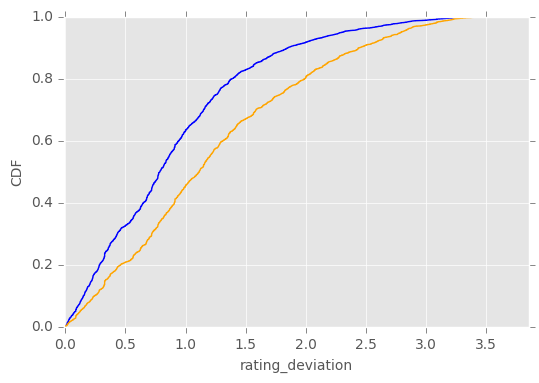

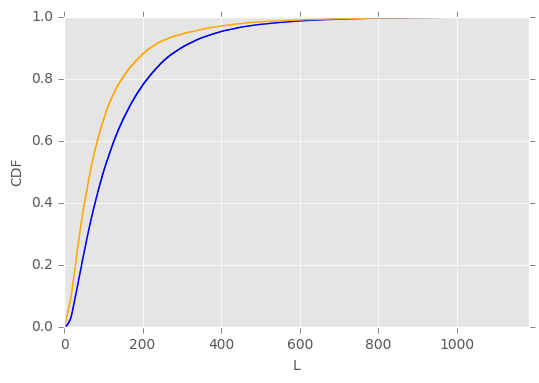

In [61]:
# review feature plot CDF (Pittsburgh)
review_df = pd.read_csv('labeled_data/review_features_labeled.tsv', delimiter='\t')

label = review_df['label']

df = review_df.drop(['rank', 'posScore', 'PCW', 'ext_rating', 'RES', 'rank_ratio', 'onePP', 'k', 'biz', 'user', 'rating', 'negScore', 'SW', 'date', 'PC', 'OW', 'rank_time_frame', 'label'], 1)

for feature_name in df.columns:
    plotCDF(df[feature_name], label, feature_name, 'review')

From the plots shown above, we can see that recommended reviews tend to have lower rating deviation, meaning that their ratings are more consistent. The reason is that spammers usually give different ratings from normal customers. Moreover, they are more likely to give extremely ratings, which might also results in higher rating deviation. In the second plot, we see that the length of nonrecommended reviews is inclined to be shorter, one reason is that spammers usually don't spend much time on a single review. From another point of view, shorter review usually carry less useful information for views, which are more likely to be catagorized as nonrecommended one.

##### Users (Pittsburgh)

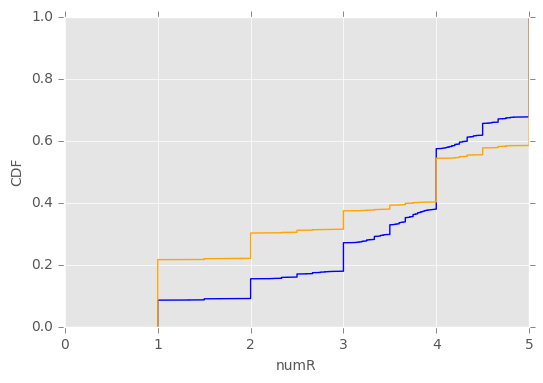

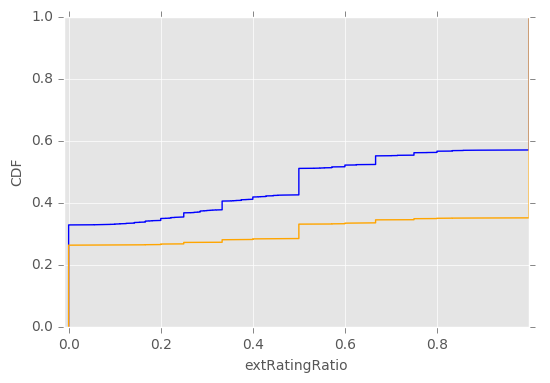

In [62]:
# user feature plot CDF (Pittsburgh)
user_df = pd.read_csv('../data/user_features.tsv', delimiter='\t')

label = user_df['fraction'].values > 0.5

df = user_df.drop(['numRecR', 'numNonRecR','avgRanks', 'res_fractions', 'stdL', 'avgRating', 'minRankTimeFrameavgRD', 'posRatingRatio', 'maxRD', 'minRanks', 'negRatingRatio', 'avgPC', 'maxRES', 'maxOnePP', 'avgOnePP', 'avgRES', 'maxPosScore', 'avgPosScore', 'maxSW', 'avgPCW', 'avgSW', 'avgNegScore', 'avgPC.1', 'minRankRatio', 'avgRankTimeFrame', 'avgRankRatio', 'avgL', 'maxPCW', 'maxNegScore', 'avgOW', 'maxOW', 'maxRDay', 'k', 'fraction'], 1)

for feature_name in df.columns:
    plotCDF(df[feature_name], label, feature_name, 'user')


According to these CDF plots, first of all, we see that spammers are more likely to have less number of reviews in Pittsburgh because normally they write spam reviews for restaurants from different places. In Contrast, recommended users tend to write more number of reviews in particular place. In the second plot, we also see that recommended users use less extreme ratings like 1 star or 5 stars, which are more likely to be given by spammers in our opinion.

##### Restaurants (Pittsburgh)

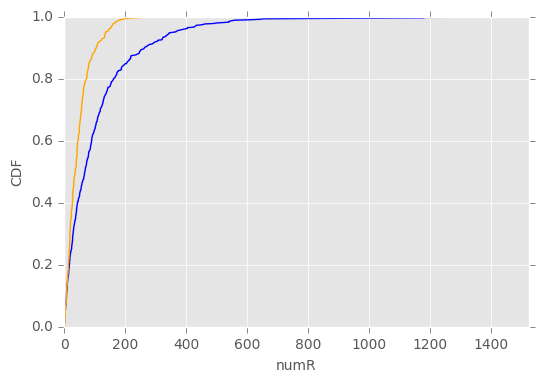

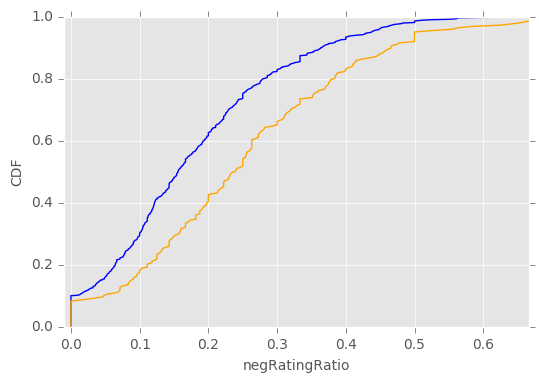

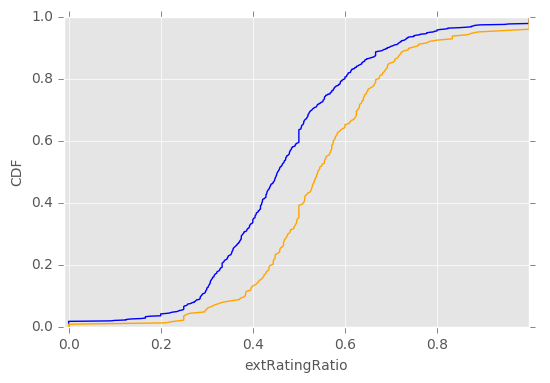

In [63]:
# restaurant feature plot CDF (Pittsburgh)
rest_df = pd.read_csv('../data/restaurant_features_labeled.tsv', delimiter='\t')

label = rest_df['fraction'].values > 0.2

df = rest_df.drop(['maxRD', 'k', 'numRecR', 'maxRDay', 'maxPCW', 'avgRating', 'avgRD', 'posRatingRatio', 'maxSW', 'avgRES', 'maxRES', 'maxPosScore', 'maxNegScore', 'avgL', 'stdL', 'avgPCW', 'avgPC', 'avgPC.1', 'avgOnePP', 'maxOnePP', 'avgPosScore', 'avgNegScore', 'avgSW', 'avgOW', 'maxOW', 'numNonRecR', 'fraction'], 1)

for feature_name in df.columns:
    plotCDF(df[feature_name], label, feature_name, 'restaurant')

In the first plot, we see that nonrecommended restaurant have less number of reviews than recommended ones. We think the reason is that restaurants that needs spammers write spam reviews for them are more likely to have poor popularity, which is positively relative to number of reviews. In the second plot, it shows that recommended restaurants tend to have smaller negative rating ratio. We believe it's because well-rated restaurants are less likely to have spammers. Third, nonrecommended restaurants have larger extreme rating ratio because spam reviews usually come with extreme ratings.

##### Reviews (NYC)

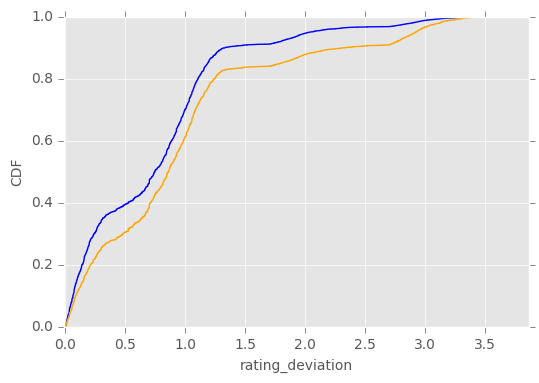

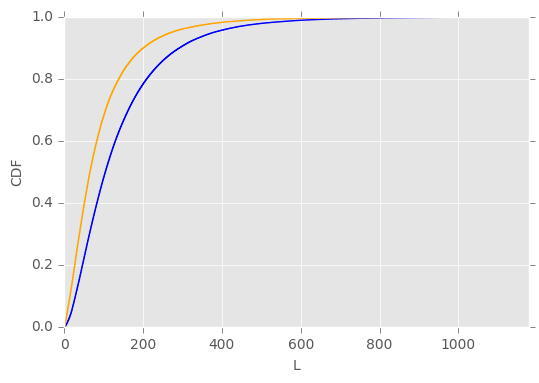

In [64]:
# review feature plot CDF (NYC)
review_df = pd.read_csv('../data/review_features_nyc.tsv', delimiter='\t')

label = review_df['label']

df = review_df.drop(['k', 'rank', 'RES', 'rank_ratio', 'ext_rating', 'PCW', 'PC', 'onePP', 'posScore', 'negScore', 'SW', 'OW', 'biz', 'user', 'rating', 'date', 'rank_time_frame', 'label'], 1)

for feature_name in df.columns:
    plotCDF(df[feature_name], label, feature_name, 'review')

From the reviews data of NYC, the pictures shows the similar fact as in Pittsburgh that recommended reviews have smaller rating reviation and shorter reivew length.

##### Users (NYC)

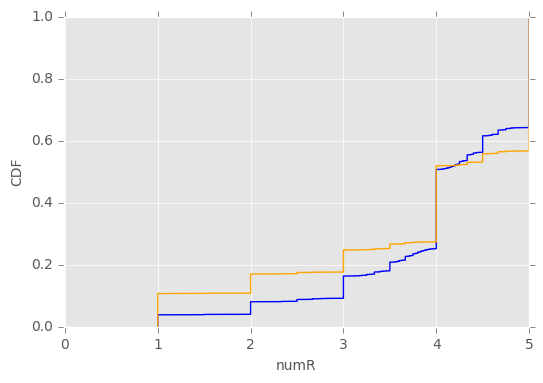

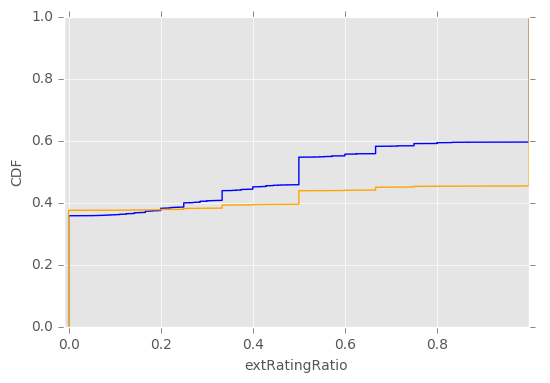

In [66]:
# user feature plot CDF (NYC)
user_df = pd.read_csv('../data/user_features_nyc.tsv', delimiter='\t')

# print user_df
label = user_df['fraction'].values > 0.5

df = user_df.drop(['k', 'numRecR', 'numNonRecR', 'avgRating', 'posRatingRatio', 'minRanks', 'minRankRatio', 'stdL', 'minRankTimeFrameavgRD', 'negRatingRatio', 'maxRES', 'res_fractions', 'maxRDay', 'avgRanks', 'avgRankRatio', 'avgRankTimeFrame', 'maxRD', 'avgL', 'avgPCW', 'maxPCW', 'avgPC', 'avgPC.1', 'avgOnePP', 'maxOnePP', 'avgRES', 'avgPosScore', 'maxPosScore', 'avgNegScore', 'maxNegScore', 'avgSW', 'maxSW', 'avgOW', 'maxOW', 'fraction'], 1)

for feature_name in df.columns:
    plotCDF(df[feature_name], label, feature_name, 'user')


Here it also shows that the number of reivews and extreme rating ratio show similar tendency and contribution to ones of Pittsburgh.

##### Restaurants (NYC)

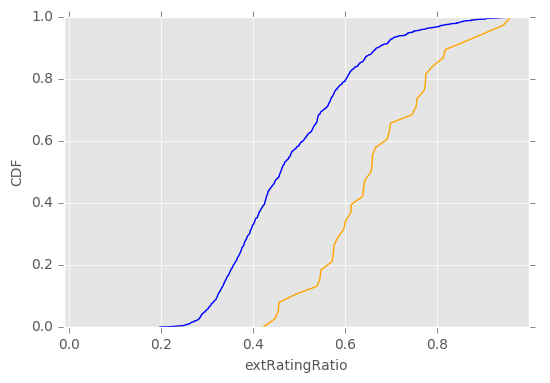

In [68]:
# restaurant feature plot CDF (NYC)
rest_df = pd.read_csv('../data/restaurant_features_nyc.tsv', delimiter='\t')

label = rest_df['fraction'].values > 0.2

df = rest_df.drop(['k', 'numR', 'negRatingRatio', 'avgRD', 'maxRD', 'avgRating', 'maxRES', 'maxSW', 'posRatingRatio', 'maxRDay', 'maxPCW', 'avgRES', 'avgL', 'stdL', 'avgPCW', 'avgPC', 'avgPC.1', 'maxNegScore', 'avgSW', 'avgOW', 'maxOW', 'avgOnePP', 'maxOnePP', 'avgPosScore', 'maxPosScore', 'avgNegScore', 'numRecR', 'numNonRecR', 'fraction'], 1)

for feature_name in df.columns:
    plotCDF(df[feature_name], label, feature_name, 'restaurant')

Similarily, this plot shows the same inclination and with better seperation of two lines, which means that extreme rating ratio has good contribution to our classifier.

## Modeling

### Review feature model

In the review datasets, we have the label of whether it is a recommend review or not. We use that label as our output and implement 5 machine learning model to train.

- SVM (Support vector machine)
- MLP (Multilayer perceptron)
- KNN (K-nearest neighbors algorithm)
- Decision Tree
- Logistic Regression

We split all the datasets into train(80%) and validation(20%), drop the redundant column and train our models.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('review_features_labeled.TSV', delimiter='\t')
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'])
X_tr = train.drop(['k', 'biz', 'user', 'date', 'label'], axis=1)
y_tr = train['label']
X_te = test.drop(['k', 'biz', 'user', 'date', 'label'], axis=1)
y_te = test['label']
print float(df[df.label == 1].shape[0]) / float(df.shape[0])

0.855908367344


### User features model

Unlike the review model, user dataset didn't have labels to check whether it is suspicious user or not. Instead, it hase a feature called "fraction" which is the fraction of non recommend review and others. User fraction that exceed 0.5 (more then half of his/her review is non recommend) will be mark as suspicious spammer.


In [15]:
from sklearn.model_selection import train_test_split

df['label'] = df.fraction.apply(lambda x: 1 if x > 0.5 else 0)
print float(df[df.label == 0].shape[0]) / float(df.shape[0])

train, test = train_test_split(df, test_size = 0.2, stratify = df['label'])
X_tr = train.drop(['numNonRecR','numRecR','k', 'fraction', 'label'], axis=1)
y_tr = train['label']
X_te = test.drop(['numNonRecR','numRecR','k', 'fraction', 'label'], axis=1)
y_te = test['label']

0.986577181208


## Dectecting Suspicious Restaurants

Now we are able to detect spam reviews and also capture spammers. However, from Yelp’s point of view, even if they can capture spammers and block their account, they still can keep posting spam review with new account. Hence, in order to avoid it, we might want to detect suspicious restaurants and deliver warning to them.
Since we are able to detect spams and spammers, we can track the distribution of spam review of a restaurant over time. Here we first make some assumptions. For example, we might assume that if a restaurant has relatively more spam review in early stage, it might be hiring people writing spam review to increase popularity. On the other hand, if a restaurant has unusual frequent spam review, it might be set up by its competitors. 


### Restaurant feature model

The restaurant dataset didn't have the label to check whether it is suspicious restaurant or not. Like the user datasets, it hase a feature called "fraction" which is the fraction of non recommend review and others. We defined the average fraction of all review 0.17 as our standard. Restaurant fraction that exceed the standard will be mark as suspicious restaruant 

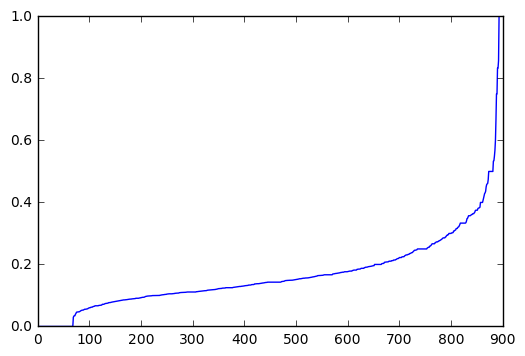

In [13]:
df = pd.read_csv('restaurant_features_labeled.TSV', delimiter='\t')
fraction = df['fraction'].as_matrix();
fraction = np.sort(fraction)
plt.plot(fraction)
plt.show()

In [14]:
df['label'] = df.fraction.apply(lambda x: 1 if x > 0.17 else 0)
print float(df[df.label == 0].shape[0]) / float(df.shape[0])


train, test = train_test_split(df, test_size = 0.2, stratify = df['label'])
X_tr = train.drop(['numNonRecR','numRecR','k', 'fraction', 'label'], axis=1)
# X_tr = train[['negRatingRatio', 'avgRD']]
y_tr = train['label']
X_te = test.drop(['numNonRecR','numRecR','k', 'fraction', 'label'], axis=1)
# X_te = test[['negRatingRatio', 'avgRD']]
y_te = test['label']

0.643176733781


### Apply the datasets to model

In [7]:
#MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(X_tr,y_tr)
y_pre = clf.predict(X_te)
print np.mean(y_pre==y_te)

0.856022978876


In [8]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(3)
clf.fit(X_tr,y_tr)
y_pre = clf.predict(X_te)
print np.mean(y_pre==y_te)

0.821614505416


In [9]:
#DT
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_tr,y_tr)
y_pre = clf.predict(X_te)
print np.mean(y_pre==y_te)

0.856920591227


In [10]:
#log
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_tr,y_tr)
y_pre = clf.predict(X_te)
print np.mean(y_pre==y_te)

0.855903297229


### Classification report

Get the precision recall and f1-score to analyze the performance of the model.

In [11]:
from sklearn.metrics import classification_report
target_names = ['Spammer', 'Not spammer']
print classification_report(y_te, y_pre, target_names=target_names)

             precision    recall  f1-score   support

    Spammer       0.50      0.00      0.01      2408
Not spammer       0.86      1.00      0.92     14303

avg / total       0.81      0.86      0.79     16711



## Result analyze

### Review classification report

The classification report generate three indicator for us to analyze.
- precision: The number of correct results divided by the number of all returned results.
- recall: The number of correct results divided by the number of results that should have been returned.
- f1-score: A measure that combines precision and recall




|      |             |precision|recall|f1-score|support|score|
|------|------------|---------|------|--------|-------|-----|
|review|             |         |      |        |       |0.856|
| MLP  | Not spammer |0.86     |   1  | 0.92   |14303  |0.860|
|      | Spammer     |0.54     |0.02  |0.03    |2408   |     |
|      | avg / total |0.81     |0.86  |0.79    |16711  |     |
| KNN  | Not spammer |0.86     | 0.94 | 0.90   |14303  |0.824|
|      | Spammer     |0.24     | 0.11 | 0.15   |2408   |     |
|      | avg / total |0.77     | 0.82 | 0.79   |16711  |     |
| DT   | Not spammer |0.86     |   1  | 0.92   |14303  |0.855|
|      | Spammer     |0.66     |0.02  |0.04    |2408   |     |
|      | avg / total |0.83     |0.86  |0.79    |16711  |     |
| Log  | Not spammer |0.85     |   1  | 0.92   |14303  |0.854|
|      | Spammer     |0.56     |0.01  |0.01    |2408   |     |
|      | avg / total |0.81     |0.85  |0.79    |16711  |  -  |

All the models yield a pretty same result. The recall score of the spammer are very low, it means that our models can not find the real spammer effectively. It can not tell whether this review is non recommand or not. Our feature selection is not good enough to seperate the recommand and non recommand reviews.  


### User classification report

|      |             |precision|recall|f1-score|support|score|
|------|-------------|---------|------|--------|-------|-----|
|user  |             |         |      |        |       |0.756|
| MLP  | Not spammer |0.77     | 0.97 | 0.86   |5315   |0.756|
|      | Spammer     |0.51     | 0.11 |0.18    |1719   |     |
|      | avg / total |0.71     | 0.76 |0.69    |7032   |     |
| KNN  | Not spammer |0.78     | 0.86 | 0.81   |5315   |0.705|
|      | Spammer     |0.35     | 0.24 | 0.28   |1719   |     |
|      | avg / total |0.67     | 0.71 | 0.68   |7032   |     |
| DT   | Not spammer |0.78     | 0.96 | 0.86   |5315   |0.768|
|      | Spammer     |0.59     | 0.18 |0.27    |1719   |     |
|      | avg / total |0.73     | 0.77 |0.72    |7032   |     |
| Log  | Not spammer |0.78     | 0.87 | 0.87   |5315   |0.773|
|      | Spammer     |0.63     | 0.27 |0.27    |1719   |     |
|      | avg / total |0.74     | 0.72 |0.72    |7032   |  -  |

In the user classificaiton, the recall score for spammer is better then the review model. The best model for our dataset is logistic regression classifier. It can catch up to 27% of sapmmer with 0.63 of accuracy. 

In this datasets, we only collect the user who reviewed in Pittsburgh area, other reviews in other city from the same user are not take into consider in our model. Therefore, the number of review per user are either alot (lived in Pittsbursh area) or just only one (visters). This might led to the bad result of our classifcation model.     


### Restaurant classification report

|      |             |precision|recall|f1-score|support|score|
|------|-------------|---------|------|--------|-------|-----|
|Restaurant|             |         |      |        |       |0.643|
| SVM  | Not spammer |0.70     | 0.90 | 0.79   |115   |0.687|
|      | Spammer     |0.62     | 0.31 |0.42    |64   |     |
|      | avg / total |0.67     | 0.69 |0.65    |179   |     |
| MLP  | Not spammer |0.69     | 0.90 | 0.78   |115   |0.670|
|      | Spammer     |0.59     | 0.27 |0.37    |64   |     |
|      | avg / total |0.67     | 0.67 |0.63    |179   |     |
| KNN  | Not spammer |0.70     | 0.74 | 0.72   |115   |0.626|
|      | Spammer     |0.47     | 0.42 | 0.45   |64   |     |
|      | avg / total |0.62     | 0.63 | 0.62   |179   |     |
| DT   | Not spammer |0.71     | 0.76 | 0.73   |115   |0.642|
|      | Spammer     |0.50     | 0.44 |0.47    |64   |     |
|      | avg / total |0.63     | 0.64 |0.64    |179   |     |
| Log  | Not spammer |0.73     | 0.88 | 0.80   |115   |0.709|
|      | Spammer     |0.65     | 0.41 |0.50    |64   |     |
|      | avg / total |0.70     | 0.71 |0.69    |179   |  -  |

The suspicious restaurant didn't have the true labels. Threshold between suspicious and non suspicious are defined by us. If we change this threshold, the model will perform differently. 

The Restaurant classification yield the best result among three classification model. The logistic regression best all other modles in our three classificaion casses. We can catch 41% of suspicious restaurant with 65% of accuacy. From all the three classificaions, we can realize that if there is only a few spammer (review classifier), It is hard for our model to learn features that seperate our datasets.


## Summary


### Error Analysis



### Future Work

As soon as we realize that our results are not satiesfying, we started to search for other possible feature candidates.

In [48]:
# This code is borrowed from CMU-15688 hw3 solutions
def tfidf(docs):
	all_words = set([a for a in " ".join(docs).split(" ") if a != ""])
	all_words_dict = {k:i for i,k in enumerate(all_words)}
	word_counts = [collections.Counter([a for a in d.split(" ") if a != ""]) for d in docs]

	#condtruct term frequency matrix in COO form
	data = [a for wc in word_counts for a in wc.values()]
	rows = [i for i,wc in enumerate(word_counts) for a in wc.values()]
	cols = [all_words_dict[k] for wc in word_counts for k in wc.keys()]
	X = sp.coo_matrix((data, (rows,cols)), (len(docs), len(all_words)))

	#comput IDF and IFIDF terms
	idf = np.log(float(len(docs))/np.asarray((X>0).sum(axis=0))[0])
	return X*sp.diags(idf), list(all_words)

def cosine_similarity(X):

	print ">>> in cosine_similarity"
	K = X.get_shape()[0]
	print ">>> in cosine_similarity"

	# calculate length for each doc
	lengths = []

	print ">>> calculating length of a doc"
	for j in range(K):
		row = X.getrow(j)
		leng = row.dot(row.transpose()).toarray().tolist()[0][0]
		lengths.append(math.sqrt(leng))

	lengths = np.array(lengths)[:,None].transpose()
	print lengths.shape

	resArr = X.dot(X.transpose()).astype(np.float64)
	print resArr.shape
	
	f_out = open('output/review_cos_sim_test.tsv', 'w')

	XT = X.transpose()
	for j in range(K):
		print ">>> calculating cos_similarity for doc: " + str(j)
		row = X.getrow(j)
		sim = row.dot(XT)
		sim = sim / lengths
		sim = sim / lengths[0,j]
		f_out.write("\t".join(format(x, "10.4f") for x in sim[0].tolist()[0]) + "\n")

In [47]:
import io
from datetime import *
from time import *
import math
from utilities import *
import numpy as np

#####################
# main
#####################

f_content = io.open('input/reviews_content_all.tsv', 'r', encoding='utf8')
f_meta = open('input/metaData_all.tsv', 'r')
f_biz = io.open('input/businessesIdMapping.tsv', 'r', encoding='utf8')

bizs = [line.rstrip('\n\r').split('\t')[1] for line in f_biz]

reviews = {}
content_lines = [line.rstrip('\n\r').split('\t') for line in f_content]

for content_line in content_lines:
    reviews[content_line[0]] = {
        'id': content_line[1],
        'text': content_line[2],
    }

meta_lines = [line.rstrip('\n\r').split('\t') for line in f_meta]

for meta_line in meta_lines:

    reviews[meta_line[0]]['user'] = meta_line[1]
    reviews[meta_line[0]]['biz'] = int(meta_line[2])
    reviews[meta_line[0]]['rating'] = float(meta_line[3])
    reviews[meta_line[0]]['label'] = int(meta_line[4])
    reviews[meta_line[0]]['date'] = datetime.strptime(meta_line[5], '%Y-%m-%d')

reviewsIdMap = {}

for k, v in reviews.iteritems():
    reviewsIdMap[v['id']] = {
        'text': v['text'],
        'user': v['user'],
        'biz': bizs[int(v['biz']) - 1],
        'rating': v['rating'],
        'label': v['label'],
        'date': v['date'],
    }

print len(reviewsIdMap)

text = reviewsIdMap['aVT6N0mvnM5vmr2_igf1QQ']['text']

docs_text = [" ".join(tokenize(v['text'])) for k, v in reviewsIdMap.iteritems()]

ks = [k for k, v in reviewsIdMap.iteritems()]

print ">>> building tfidf features for docs"
(tfidf, all_words) = tfidf(docs_text)

print ">>> computing pairwise cos-simiarity using tfidf features"
cosine_similarity(tfidf[0:10,])

f_out = io.open('output/review_cos_sim_key.tsv', 'w', encoding='utf8')
f_out.write("\n".join(ks) + "\n")




83551
>>> building tfidf features for docs
>>> computing pairwise cos-simiarity using tfidf features
>>> in cosine_similarity
>>> in cosine_similarity
>>> calculating length of a doc
(1, 10)
(10, 10)
>>> calculating cos_similarity for doc: 0
>>> calculating cos_similarity for doc: 1
>>> calculating cos_similarity for doc: 2
>>> calculating cos_similarity for doc: 3
>>> calculating cos_similarity for doc: 4
>>> calculating cos_similarity for doc: 5
>>> calculating cos_similarity for doc: 6
>>> calculating cos_similarity for doc: 7
>>> calculating cos_similarity for doc: 8
>>> calculating cos_similarity for doc: 9


1921673L

Output of the previous program is a K by K matrix where Matrix[i][j] is the cos-similarity between document i and document j
<pre>
    1.0000	    0.0073	    0.0238	    0.0983	    0.0344	    0.0363	    0.0164	    0.0073	    0.0264	    0.0480
    0.0073	    1.0000	    0.0215	    0.0215	    0.0698	    0.0113	    0.0179	    0.0238	    0.0190	    0.0168
    0.0238	    0.0215	    1.0000	    0.0073	    0.0395	    0.0242	    0.0124	    0.0369	    0.0184	    0.0397
    0.0983	    0.0215	    0.0073	    1.0000	    0.0512	    0.0054	    0.0105	    0.0032	    0.0346	    0.0283
    0.0344	    0.0698	    0.0395	    0.0512	    1.0000	    0.0343	    0.0522	    0.0336	    0.0485	    0.0559
    0.0363	    0.0113	    0.0242	    0.0054	    0.0343	    1.0000	    0.0760	    0.0327	    0.0293	    0.0519
    0.0164	    0.0179	    0.0124	    0.0105	    0.0522	    0.0760	    1.0000	    0.0306	    0.0716	    0.0145
    0.0073	    0.0238	    0.0369	    0.0032	    0.0336	    0.0327	    0.0306	    1.0000	    0.0079	    0.0396
    0.0264	    0.0190	    0.0184	    0.0346	    0.0485	    0.0293	    0.0716	    0.0079	    1.0000	    0.0255
    0.0480	    0.0168	    0.0397	    0.0283	    0.0559	    0.0519	    0.0145	    0.0396	    0.0255	    1.0000
</pre>

Although we could not finish running the cos-similarity between each pair of the documents(It has to compute 80000 * 80000 pairwise vector multiplication), we expect this feature should boost our model performance because cos-similarity allow us to analyze the following attributes.

* Within user similarity: whether a user always write similar reviews (maybe copy and paste?)
* Within restaurant similarity: whether a user writes a review that is very different from other reviews given to the same restaurant
* Within class similarity: how similar is a review to other recommend/non-recommend reviews

The third feature is a standard text classification while the first two incorporate with graph model and should help a lot when detecting abnormality.

Given the bottleneck is the runtime and the size of the review. We may consider reduce the size of word features, that is, we now have about 160000 unique words in our training set and we take every of them as a dimension when calculating cos-similarity. The truth is, most of them do not provide much information toward similarity so we may consider dropping them to reduce complexity. As for the review size, 80000 * 80000 is a huge size for a dense array so we may consider distribute(map-reduce) this calculation to separate workers and collect the results at the end given each calculation only takes two vectors to multiply.

After all, we already learned a lot through out the process, we obtain tons of data from web and contruct a graph relationship within the raw data. We learned how to investigate the data using visualization tools and statistical summarization. We then make assumptions about models and features and finally test our assumptions. We also experienced the frustration of not getting good results but we were able to slightly improve them by doing error analysis. We believe this project actully gives us confidence in future challenges of working with data and finding insightful results.